# Investigating Factors of Rising House Values in New York City: Step 2 (Analysis)

Team Members: Francisco Brady (fbrady), Zhonghan Xie (jonasxie), Michael Garner (mngarner)  
Date: 2024-11-06

## Background and Guiding Questions

As house prices continue to rise in New York City, the ripple effects on communities are profound. For example, the median home price in NYC reached approximately \$754,000 as of September 2024, 29.5\% increase from that of September 2017. While rapidly increasing property values may signal economic growth, they also contribute to housing instability and displacement, particularly among lower-income residents. At the same time, access to quality educational resources remains a crucial factor for many families in deciding where to live. In areas where public schools are highly rated and well-attended, home prices often exceed city averages, reflecting the economic value of educational resources placed on educational quality. This project aims to investigate the factors that contribute to rising house prices in NYC, their impact on eviction rates and the intersection between educational outcomes and housing markets. By understanding these relationships, we hope to inform policymakers and community stakeholders on how to address the challenges of access to quality education, housing affordability and stability in the city.

Three questions that we seek to answer in an analysis of housing price, eviction rate, and educational datasets for NYC are:
1. What impact does rising housing prices have on eviction rates in NYC? Are these strongly correlated?
2. Does the change in eviction rate due to housing prices predict a change in primary/secondary education attendance? Specifically: do neighborhoods with higher eviction rates, potentially due to rising housing costs, see a decrease in school attendance?
3. How do the relationships between housing prices, eviction rates, and education vary across different neighborhoods in NYC? Do the predictive relationships differ in locations with different socioeconomic characteristics?

## Data Pre-processing

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Import merged neighborhood-level dataset
allData = pd.read_csv('./data/analytic_dataset.csv')

In [3]:
# Streamline dataset to keep columns of interest for this analysis
keepCols = ['year', 'nta_name', 'borough', 'pct_attendance',
       'pct_chronically_absent', 'EVICTION_COUNT',
       'median_sale_price', 'hvi', 'total_population',
       'median_income', 'white_pct', 'black_pct',
       'american_indian_alaska_native_pct', 'asian_pct',
       'hawaiian_pacific_islander_pct', 'multiple_race_pct', 'other_race_pct']
data = allData[keepCols]

# Rename column for format
data.rename(columns={'EVICTION_COUNT': 'num_evictions'}, inplace=True)

# Drop rows with missing values
data = data.dropna()
data.sample(10)

C:\Users\Michael Garner\AppData\Local\Temp\ipykernel_30072\3131118523.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'EVICTION_COUNT': 'num_evictions'}, inplace=True)


,year,nta_name,borough,pct_attendance,pct_chronically_absent,num_evictions,median_sale_price,hvi,total_population,median_income,white_pct,black_pct,american_indian_alaska_native_pct,asian_pct,hawaiian_pacific_islander_pct,multiple_race_pct,other_race_pct
17665,2019.0,Bedford-Stuyvesant (West),Brooklyn,82.717819,56.871037,2.0,1250000.0,8.811769e+05,1874.0,30455.0,41.355,33.031,0.000,2.081,0.000,17.609,14.728
15833,2020.0,Flatbush,Brooklyn,93.451561,21.856287,5.0,1065000.0,7.051627e+05,4949.0,37042.0,18.428,55.466,4.526,3.233,0.000,13.781,11.457
41795,2019.0,Astoria (East)-Woodside (North),Queens,93.304512,22.531645,4.0,1157500.0,8.108902e+05,3675.0,39805.0,44.381,1.197,0.000,33.333,0.000,23.510,9.333
61061,2022.0,Bedford Park,Bronx,87.826424,47.676769,13.0,770000.0,2.155080e+05,8904.0,26210.0,15.218,12.972,0.000,2.358,0.000,6.536,66.184
56130,2022.0,Longwood,Bronx,87.351234,54.126678,2.0,745500.0,4.091041e+05,5948.0,24786.0,15.299,30.918,0.521,0.000,0.000,17.216,44.654
50896,2019.0,Sunnyside,Queens,93.527786,18.057663,6.0,914000.0,6.736012e+05,6126.0,51274.0,65.997,1.845,0.000,20.552,0.000,11.851,5.681
52015,2020.0,Elmhurst,Queens,84.848488,49.581589,1.0,988800.0,6.234786e+05,2562.0,32387.0,27.635,1.132,0.000,60.656,0.000,6.948,7.104
26408,2022.0,Kensington,Brooklyn,90.563164,34.250763,1.0,1405000.0,8.061262e+05,4044.0,36778.0,49.332,6.083,0.000,27.596,0.000,22.156,5.910
21799,2022.0,Bushwick (West),Brooklyn,79.256485,66.868690,9.0,1280000.0,8.771796e+05,4012.0,35568.0,42.173,17.797,0.773,9.297,0.000,15.852,22.034
15997,2022.0,Park Slope,Brooklyn,94.604027,10.858995,2.0,3700000.0,1.423803e+06,2724.0,72039.0,59.325,15.382,0.000,6.828,0.294,31.351,2.496


## Descriptive Statistics

Guidance:

Provide a comprehensive summary of your combined dataset using descriptive statistics. This should include means, medians, modes, ranges, variance, and standard deviations for the relevant features of your data.  The descriptive statistics should inform your guiding questions that you developed in Part I of the project, rather than merely providing an overview of your data.  Interpret these results to draw preliminary conclusions about the data.

In [4]:
# Descriptive statistics for the key variables: evictions, school absenteeism, housing prices
# Mean, median, mode, std dev, range, IQR, etc
# Box plot for each

# Filter to numeric columns
catCols = ['year', 'nta_name', 'borough']
numData = data.drop(catCols, axis=1)
numData.describe().T

# Add mode, range, IQR to descriptive statistics
stats = numData.describe().T
stats['mode'] = numData.mode().apply(lambda x: x.dropna().tolist())
stats['range'] = stats['max'] - stats['min']
stats['IQR'] = stats['75%'] - stats['25%']
stats['variance'] = stats['std'] ** 2
stats

,count,mean,std,min,25%,50%,75%,max,mode,range,IQR,variance
pct_attendance,35936.0,8.960479e+01,5.202579e+00,55.548347,86.982735,90.588730,9.337317e+01,9.954858e+01,"[73.1973114, 86.93797302, 90.56764984, 91.2075...",4.400023e+01,6.390434,2.706682e+01
pct_chronically_absent,35936.0,3.491589e+01,1.684728e+01,0.000000,22.023809,33.992096,4.724919e+01,9.324759e+01,[35.63536072],9.324759e+01,25.225382,2.838308e+02
num_evictions,35936.0,5.141223e+00,6.514691e+00,1.000000,1.000000,3.000000,6.000000e+00,7.800000e+01,[1.0],7.700000e+01,5.000000,4.244119e+01
median_sale_price,35936.0,1.639224e+06,2.287095e+06,400000.000000,682500.000000,916425.000000,1.300000e+06,1.650000e+07,[1300000.0],1.610000e+07,617500.000000,5.230805e+12
hvi,35936.0,7.382782e+05,3.406424e+05,174328.530490,524673.078599,629066.374847,9.054063e+05,3.806033e+06,[881176.8910014983],3.631705e+06,380733.222850,1.160373e+11
total_population,35936.0,4.045415e+03,1.882943e+03,386.000000,2652.000000,3738.000000,5.034000e+03,1.422000e+04,[3997.0],1.383400e+04,2382.000000,3.545476e+06
median_income,35936.0,3.714295e+04,2.037785e+04,4740.000000,24444.000000,32025.000000,4.172800e+04,2.047500e+05,"[15615.0, 42109.0]",2.000100e+05,17284.000000,4.152568e+08
white_pct,35936.0,3.565373e+01,2.707504e+01,0.000000,11.834000,27.885500,5.881200e+01,9.922600e+01,"[24.092, 63.322]",9.922600e+01,46.978000,7.330577e+02
black_pct,35936.0,3.139922e+01,3.002707e+01,0.000000,4.201000,19.692000,5.715100e+01,9.772100e+01,[0.0],9.772100e+01,52.950000,9.016248e+02
american_indian_alaska_native_pct,35936.0,4.771481e-01,1.480557e+00,0.000000,0.000000,0.000000,4.070000e-01,3.072700e+01,[0.0],3.072700e+01,0.407000,2.192048e+00


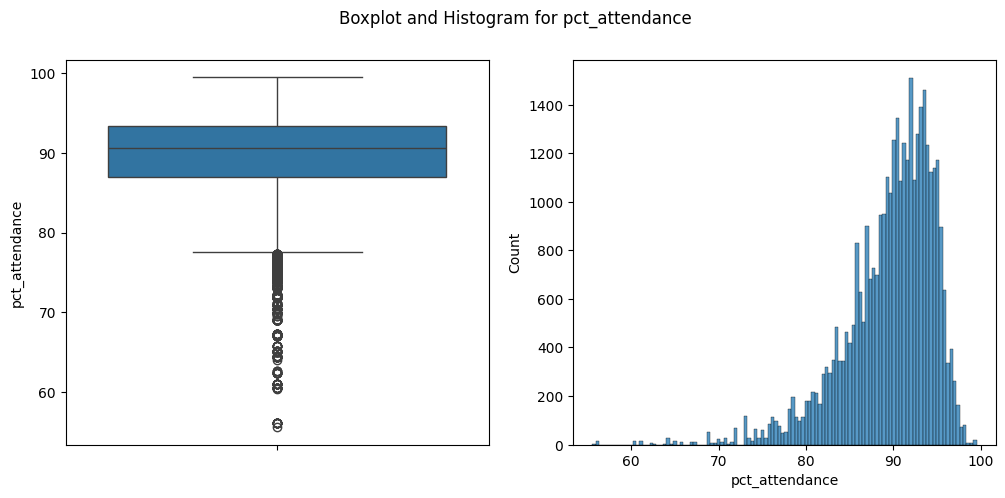

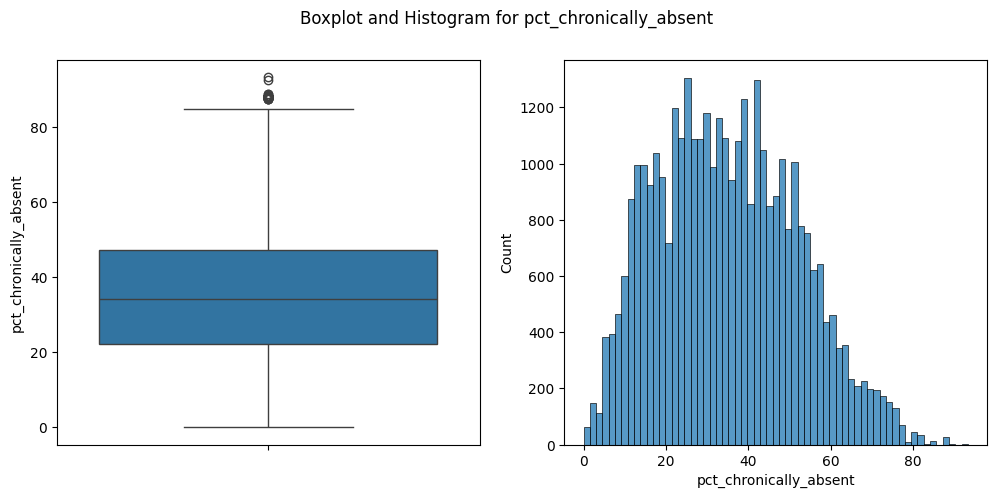

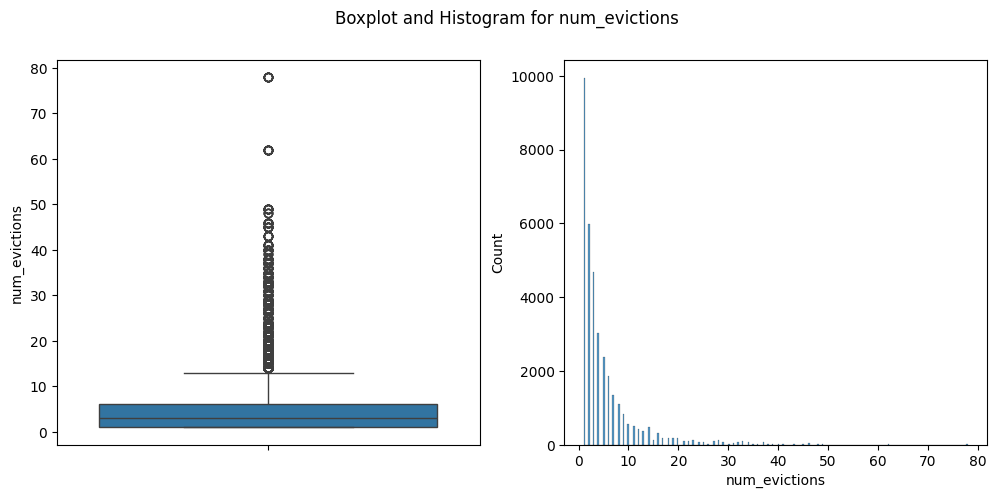

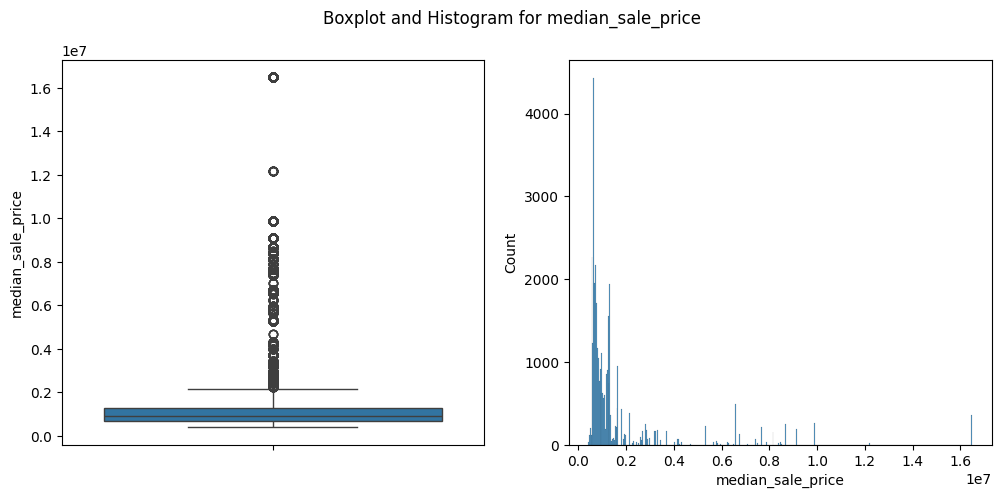

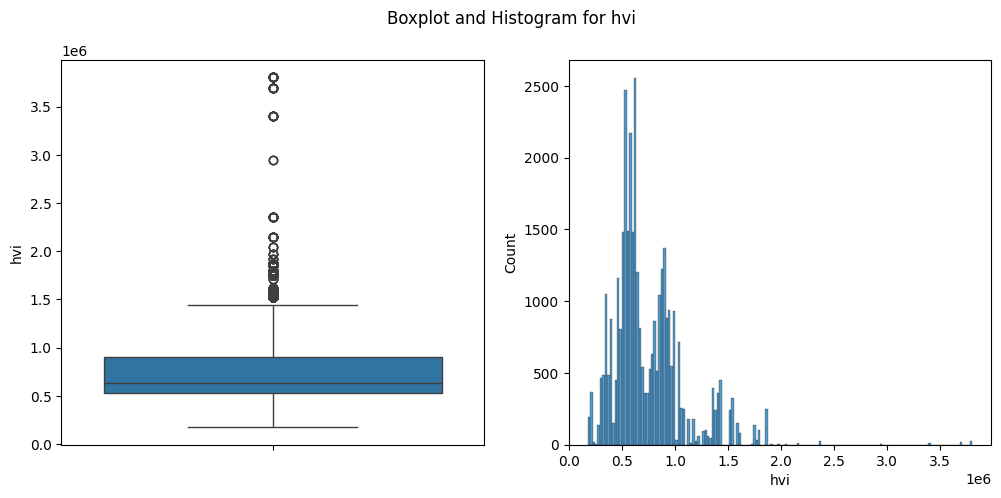

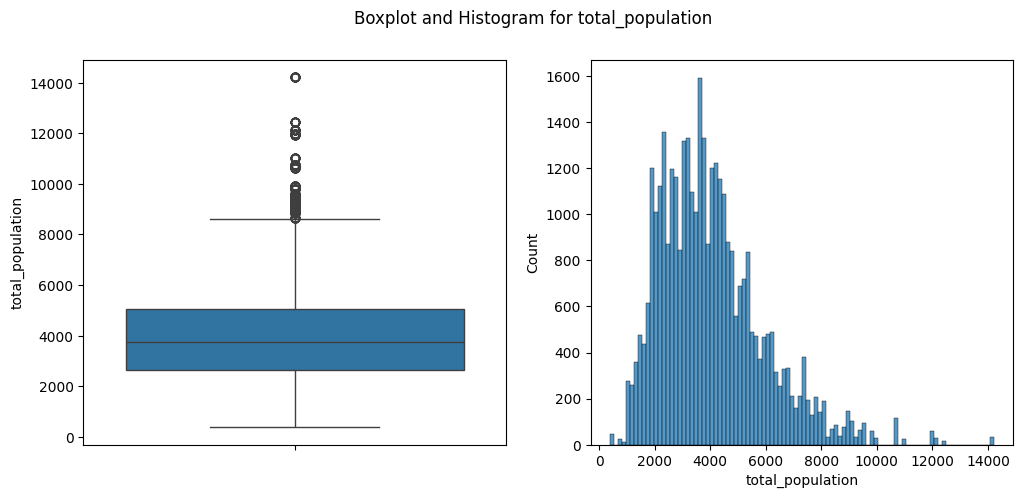

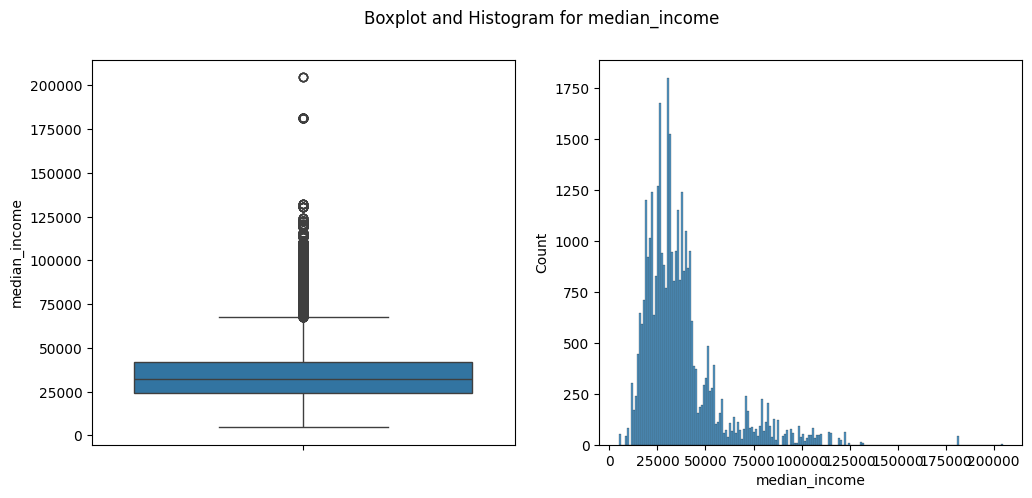

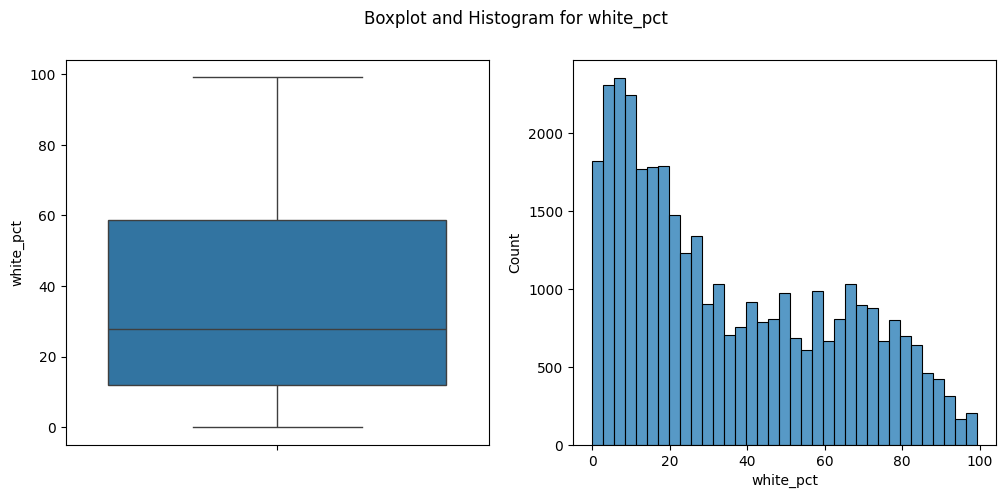

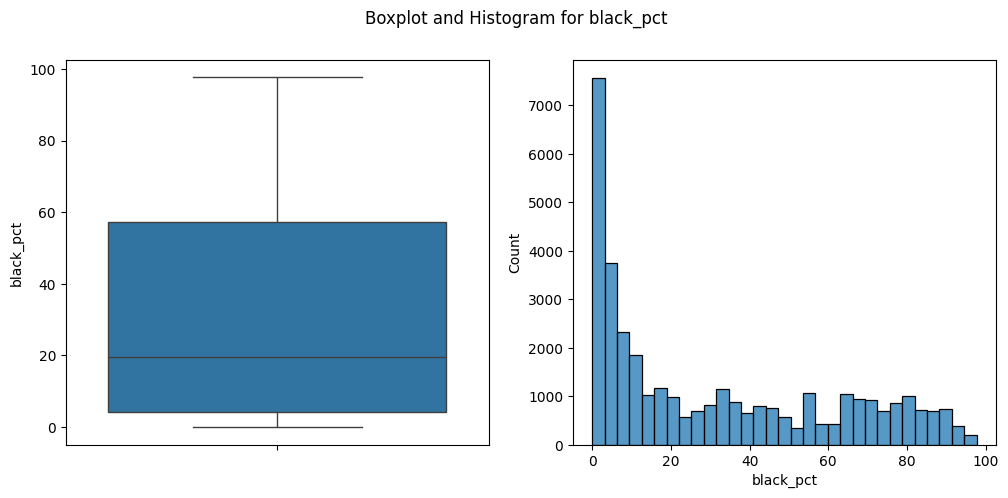

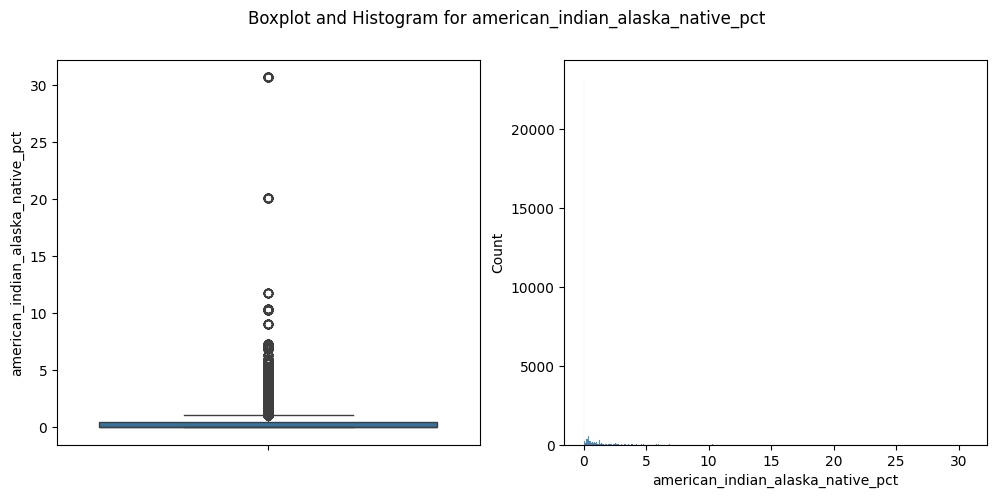

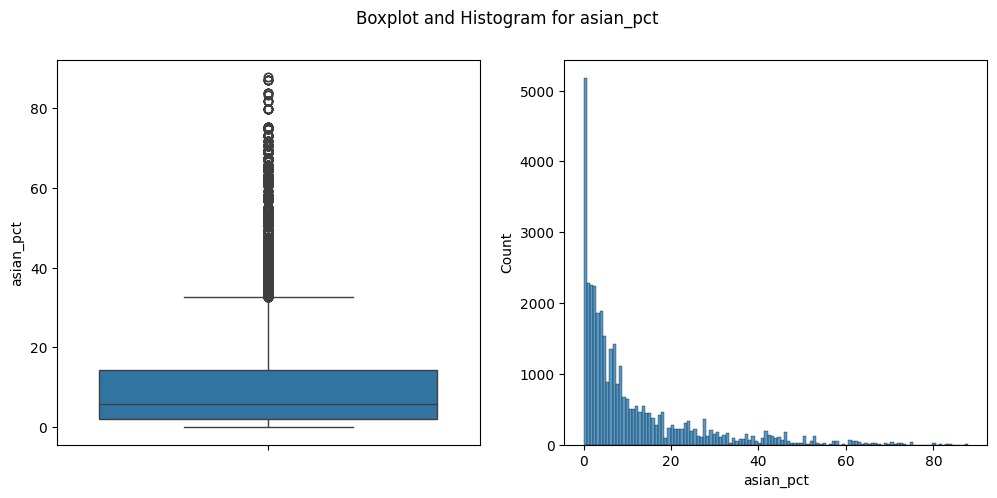

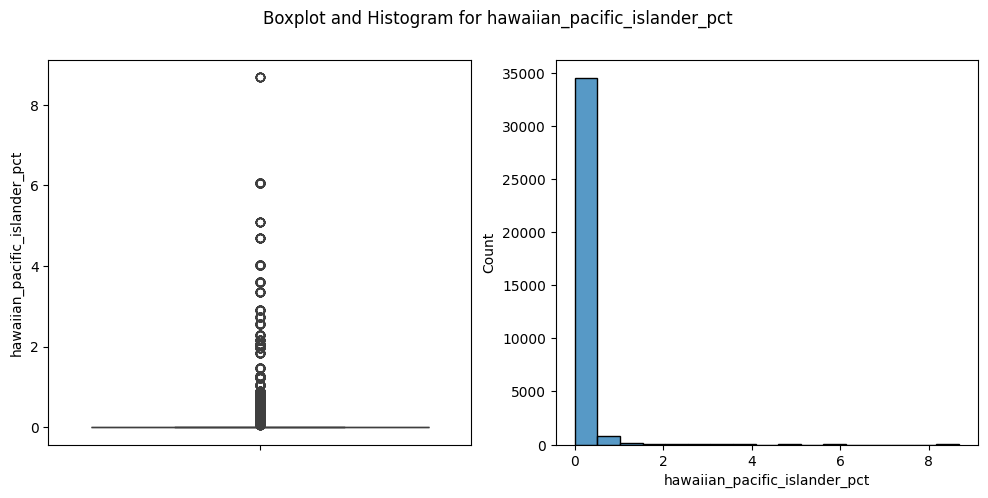

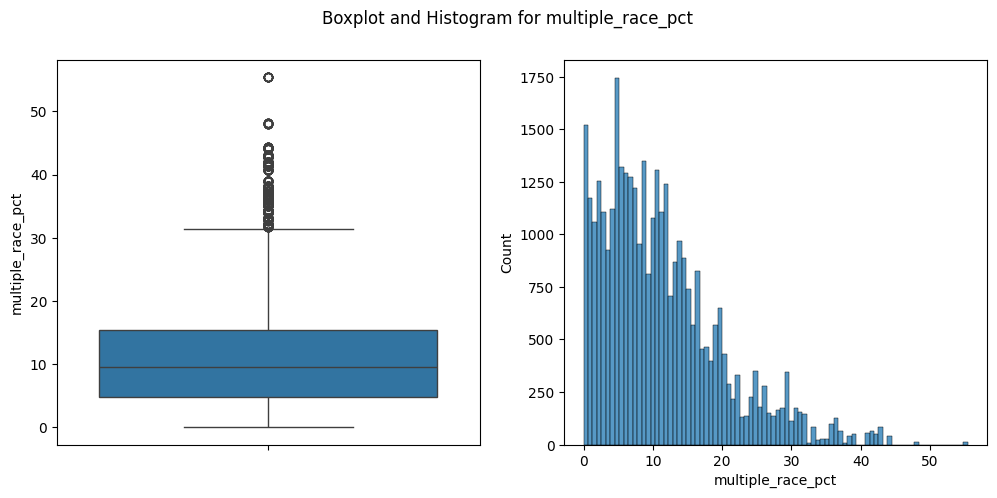

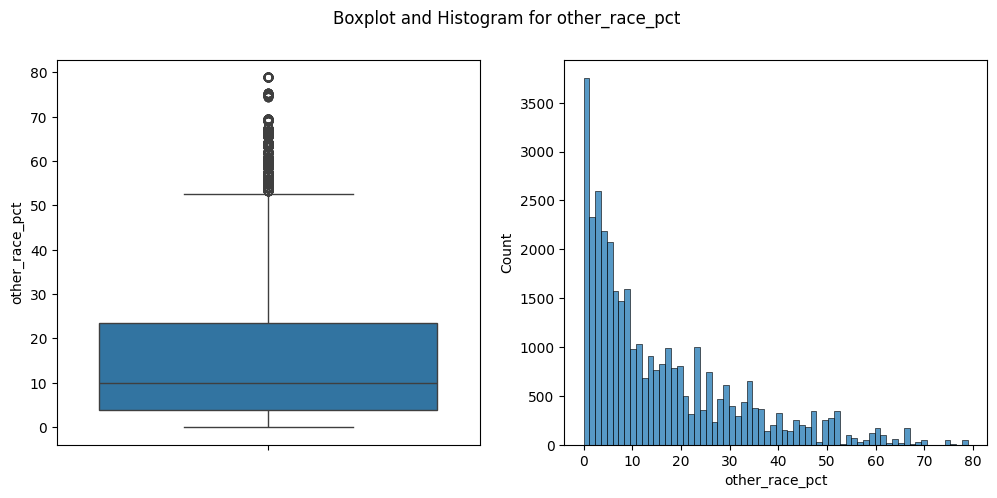

In [5]:
# Do a box plot/histogram subplot combo for each numeric variable
for col in numData.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    sns.boxplot(data=numData[col], ax=ax1)
    sns.histplot(data=numData[col], ax=ax2)
    plt.suptitle(f"Boxplot and Histogram for {col}")
    plt.show()


In this section we provide the key descriptive statistics for the numerical variables in the data set and visualize their distributions using boxplots and histograms.

Of note, all of the minority racial categories' distributions are strongly skewed right, with the majority of neighborhoods tending to have a lower percentage when looking at each race individually. Due to the many racial categories, this makes sense. The white racial category is similarly skewed, but to a lesser extent, meaning there are a number of white-dominated and non-white dominated neighborhoods.

Median income among the neighborhoods peaks around the median value of median income, 32000 USD. This figure is surprising considering the cost of living in NYC and the national figure. It also shows that high earners tend to be outliers, a strong wealth disparity.

Chronic absenteeism adopts an approximately normal distribution, and number of evictions and median income are heavily skewed to the right. These some of the most important variables to consider in our research questions. It will be interesting to see, for example, if the high-end outliers/sparseness of median income tends to line up with the low-end numbers of evictions, as we would expect that to be the case a priori. The normal unimodal distribution of chronic absenteeism also suggests that there may be multiple factors that influence it, or that the relationship is more complicated. This will need an inferential analysis, such as regression/mediation analysis, to see clearly, rather than simply comparing univariate distributions.

## Inferential Statistics

Guidance:

Conduct appropriate hypothesis tests to investigate if there are significant differences or correlations within your data.  This might involve regression analysis, ANOVA, and/or chi-squared tests.

Clearly state your null and alternative hypotheses, choose an appropriate significance level, and discuss your findings. Make sure to justify the choice of your tests.

The research questions and associated hypotheses we aim to answer in this inferential analysis are the following. Please note that some of this analysis bleeds over into the realm of a multivariate or comparative analysis (the mediation and ANOVA tests, respectively), but the authors determined it is most appropriate to include it here for a logical presentation.

1. How are housing prices related to eviction rates? Do areas with higher housing prices have higher eviction rates?
    - Null hypothesis (H0): There is no relationship between housing prices and eviction rates.
    - Alternative hypothesis (Ha): There is a positive relationship between housing prices and eviction rates.
2. Is the impact of income on eviction rates mediated by housing prices?
    - H0: There is no relationship between housing prices and the impact of income on eviction rates.
    - Ha: Housing prices mediate the relationship between income and eviction rates.
3. Do neighborhoods with higher eviction rates see a decrease in school attendance?
    - H0: There is no relationship between evictions and school attendance.
    - Ha: There is a negative association between eviction rates and school attendance.
4. Is the impact of income on school attendance mediated by evictions?
    - H0: There is no relationship between evictions and the impact of income on school attendance.
    - Ha: Evictions mediate the relationship between income and school attendance.
5. How do the relationships between housing prices, evictions, and chronic absenteeism vary between minority and white-dominant neighborhoods?
    - H0: There is no statistically significant difference in the relationships between housing prices, evictions, and chronic absenteeism between minority and white-dominant neighborhoods.
    - Ha: The relationships between housing prices, evictions, and chronic absenteeism differ between minority and white-dominant neighborhoods.
6. How do the relationships between housing prices, evictions, and chronic absenteeism vary between low, medium and high income neighborhoods?
    - H0: There is no statistically significant difference in the relationships between housing prices, evictions, and chronic absenteeism between neighborhoods of different income levels.
    - Ha: The relationships between housing prices, evictions, and chronic absenteeism differ by neighborhood income level.


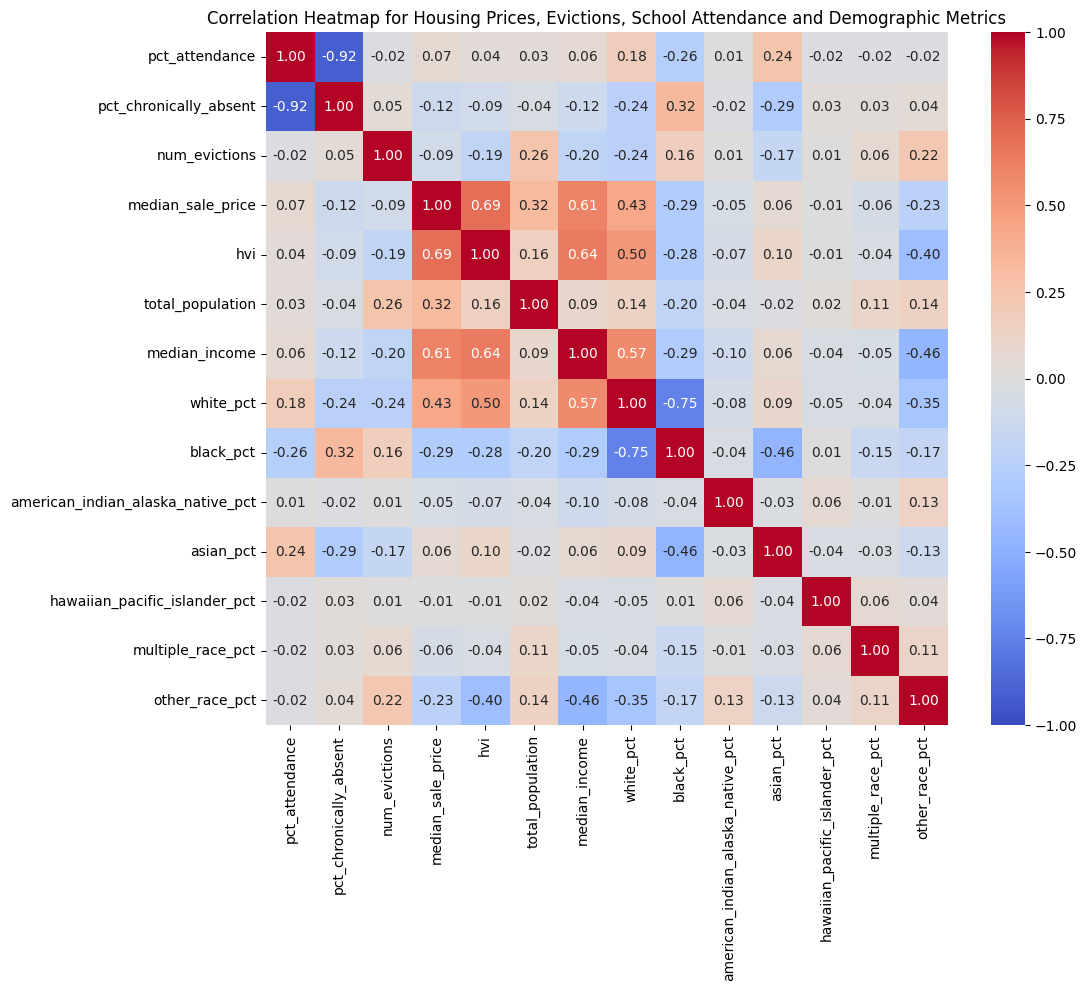

In [6]:
# Correlation heatmap for housing prices, evictions, and school chronic absenteeism
# Correlation matrix
plt.figure(figsize=(11, 9))
sns.heatmap(numData.corr(), annot=True, vmin=-1, vmax=1, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap for Housing Prices, Evictions, School Attendance and Demographic Metrics")
plt.show()

As a starting point, we plot the correlation matrix of the numerical variables of interest to get a sense of the relationships between variable pairs. In this plot, we see that most pairs have a weak correlation, from which we may infer that to predict most variables, we would need to include many other variables in a model to reach a statistically significant prediction. This makes sense when considering complex and multifactorial issues like evictions, housing prices, and how often children attend school or are chronically absent.

An obvious correlation that can be explained is that of percent chronically absent and percent attendance; these have reciprocal definitions and thus have a nearly perfect negative correlation. Another is with related measures of housing prices: hvi and median_sale price have a moderate strong positive correlation.

Correlations of note beyond the obvious include that of the racial factors and income and housing price metrics. We see a clear divide: white-dominated neighborhoods tend to have higher median incomes and housing prices/values, whereas for minority-dominated neighborhoods, there exists either no correlation or a wek negative correlation, meaning these neighborhoods tend to have lower incomes and housing prices/values. This is strongest for black and mixed race neighborhoods, and weakest for more neighborhoods with a higher asian population percentage.

Another correlation is between housing prices and income, which is expected; these metrics have a moderate-strong positive correlation.

On school attendance, we see that neighborhoods with a higher proportion of white and asian residents tend to have better attendance and lower chronic absenteeism whereas neighborhoods with a higher proportion of black residents see the opposite. Interestingly, the correlation between attendance and race is much stronger than attendance and economic factors like income and housing prices.

Finally, looking at eviction rates: we see that high-black and mixed race neighborhoods have a weak positive correlation with eviction rates with the opposite true for high white and asian neighborhoods. Evictions are also weakly correlated with income and housing prices, but not as strongly as one might expect.

In [7]:
# A. Barron-Kenny Mediation analysis: income -> housing -> evictions

# 1. Regression analysis of income and evictions
lmA1 = smf.ols('num_evictions ~ median_income', data=numData).fit()
print(lmA1.summary())

                            OLS Regression Results                            
Dep. Variable:          num_evictions   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1498.
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          5.09e-321
Time:                        10:37:25   Log-Likelihood:            -1.1760e+05
No. Observations:               35936   AIC:                         2.352e+05
Df Residuals:                   35934   BIC:                         2.352e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.5164      0.070    107.370

In [8]:
# 2. Regression analysis of income and housing prices
lmA2 = smf.ols('median_sale_price ~ median_income', data=numData).fit()
print(lmA2.summary())

                            OLS Regression Results                            
Dep. Variable:      median_sale_price   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                 2.087e+04
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        10:37:25   Log-Likelihood:            -5.6897e+05
No. Observations:               35936   AIC:                         1.138e+06
Df Residuals:                   35934   BIC:                         1.138e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -8.876e+05      2e+04    -44.489

In [9]:
# 3. Regression analysis of housing prices and evictions
lmA3 = smf.ols('num_evictions ~ median_sale_price', data=numData).fit()
print(lmA3.summary())

                            OLS Regression Results                            
Dep. Variable:          num_evictions   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     285.1
Date:                Thu, 07 Nov 2024   Prob (F-statistic):           1.05e-63
Time:                        10:37:25   Log-Likelihood:            -1.1819e+05
No. Observations:               35936   AIC:                         2.364e+05
Df Residuals:                   35934   BIC:                         2.364e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.5555      0.04

In [10]:
# 4. Multiple regression of income and housing prices on evictions
lmA4 = smf.ols('num_evictions ~ median_income + median_sale_price', data=numData).fit()
print(lmA4.summary())

                            OLS Regression Results                            
Dep. Variable:          num_evictions   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     781.5
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        10:37:25   Log-Likelihood:            -1.1757e+05
No. Observations:               35936   AIC:                         2.351e+05
Df Residuals:                   35933   BIC:                         2.352e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.6464      0.07

The above mediation analysis and regression model output summaries allow us to determine the statistical significance of the relationships between housing prices, evictions, and income, as well as whether housing prices are a mediating variable in the relationship between income and evicitons. That is, is most of the effect of income on evictions due to the effect of income on housing prices, or is it income acting alone?

From the above output summaries, we see the following statistics for the mediation analysis:
- evictions ~ median income: p = 5.09e-321, coefficient = -6.395e-05
- median housing sale price ~ median income: p = 0.0, coefficient = 68.02
- evictions ~ median housing sale price:  p = 1.05e-63, coefficient = -2.527e-07
- evictions ~ median income + median housing sale price: p = 0.0
    - mediated direct effect (median income): p = 0.0, coefficient = -7.391e-05
    - median housing sale price alone: p = 0.0

Overall, all of these p-values are less than the standard significance threshold of 0.05, indicating that each of the relationships between these variables are statistically significant and they are all independently strong predictors of each other. For the mediation analysis, we calculate the following using the product of coefficients method:
- Total Effect (evictions ~ income, unmediated): -6.395e-05
- Direct Effect (evictions ~ income, mediated, from the multiple regression): -7.391e-05
- Indirect Effect (product of coefficients of housing ~ income and evictions ~ housing): (68.02)(-2.527e-07) = -1.719e-04

We can conclude the following:
- Since the regression coefficient of the indirect effect is large and statistically significant relative to the total effect, we can conclude that housing prices play a mediating role in the relationship between income and evictions to some extent. This means that the effect of income on evictions is partially due to the effect of income on housing prices.
- Since the direct effect is slightly larger in magnitude than the total effect, we can conclude that the effect of income on evictions has both an indirect (through housing prices) and direct component. Further, that income and housing prices together are stronger predictors of evictions than income alone. This is supported by a higher R-squared value for the multiple regression model than the single regression model.

In terms of our hypotheses defined above:

1. We reject the null hypothesis that there is no relationship between median housing prices and number of evictions. There exists a statistically significant (p << 0.05) positive relationship between the two.

2. We reject the null hypothesis that housing prices do not mediate the relationship between income and evictions. Housing prices do act as a mediator, with the effect of income on evictions partially due to the effect of income on housing prices.



In [11]:
# B. Mediation analysis: income -> evictions -> absenteeism

# 1. Regression analysis of income and absenteeism
lmB1 = smf.ols('pct_chronically_absent ~ median_income', data=numData).fit()
print(lmB1.summary())

                              OLS Regression Results                              
Dep. Variable:     pct_chronically_absent   R-squared:                       0.014
Model:                                OLS   Adj. R-squared:                  0.013
Method:                     Least Squares   F-statistic:                     492.5
Date:                    Thu, 07 Nov 2024   Prob (F-statistic):          2.14e-108
Time:                            10:37:26   Log-Likelihood:            -1.5224e+05
No. Observations:                   35936   AIC:                         3.045e+05
Df Residuals:                       35934   BIC:                         3.045e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Interc

In [12]:
# 2. Regression analysis of income and evictions (already done)
print(lmA1.summary())

                            OLS Regression Results                            
Dep. Variable:          num_evictions   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1498.
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          5.09e-321
Time:                        10:37:26   Log-Likelihood:            -1.1760e+05
No. Observations:               35936   AIC:                         2.352e+05
Df Residuals:                   35934   BIC:                         2.352e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.5164      0.070    107.370

In [13]:
# 3. Regression analysis of evictions and absenteeism
lmB3 = smf.ols('pct_chronically_absent ~ num_evictions', data=numData).fit()
print(lmB3.summary())

                              OLS Regression Results                              
Dep. Variable:     pct_chronically_absent   R-squared:                       0.002
Model:                                OLS   Adj. R-squared:                  0.002
Method:                     Least Squares   F-statistic:                     78.89
Date:                    Thu, 07 Nov 2024   Prob (F-statistic):           6.87e-19
Time:                            10:37:26   Log-Likelihood:            -1.5244e+05
No. Observations:                   35936   AIC:                         3.049e+05
Df Residuals:                       35934   BIC:                         3.049e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Interc

In [14]:
# 4. Multiple regression of income and evictions on absenteeism
lmB4 = smf.ols('pct_chronically_absent ~ median_income + num_evictions', data=numData).fit()
print(lmB4.summary())

                              OLS Regression Results                              
Dep. Variable:     pct_chronically_absent   R-squared:                       0.014
Model:                                OLS   Adj. R-squared:                  0.014
Method:                     Least Squares   F-statistic:                     256.9
Date:                    Thu, 07 Nov 2024   Prob (F-statistic):          1.61e-111
Time:                            10:37:26   Log-Likelihood:            -1.5223e+05
No. Observations:                   35936   AIC:                         3.045e+05
Df Residuals:                       35933   BIC:                         3.045e+05
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Interc

The above mediation analysis and regression model output summaries allow us to determine the statistical significance of the relationships between chronic school absenteeism among children, evictions, and median income, as well as whether evictions are a mediating variable in the relationship between income and absenteeism.

From the above output summaries, we see the following statistics for the mediation analysis:
- absenteeism ~ median income: p = 2.14e-108, coefficient = -9.614e-05
- evictions ~ median income: p = 5.09e-321, coefficient = -6.395e-05
- absenteeism ~ evictions:  p = 6.87e-19, coefficient = 0.1210
- absenteeism ~ evictions + median income: p = 1.61e-111
    - mediated direct effect (absenteeism ~ income): p = 0.000, coefficient = -9.208e-05
    - absenteeism ~ num_evictions: p = 0.000, coefficient = 0.0634

Once again all of these p-values are less than the standard significance threshold of 0.05, indicating that each of the relationships between these variables are statistically significant and they are all strong predictors of each other in a pairwise sense. For the mediation analysis, we calculate the following using the product of coefficients method:
- Total Effect (absenteeism ~ income, unmediated): -9.614e-05
- Direct Effect (absenteeism ~ income, mediated, from the multiple regression): -9.208e-05
- Indirect Effect (product of coefficients of evictions ~ income and absenteeism ~ evictions): 
    = (-6.395e-05)(0.0634) = -4.05e-06

We can conclude the following:
- Since the regression coefficient is reduced when mediated, we can conclude that evictions play a mediating role in the relationship between income and absenteeism. This means that the effect of income on absenteeism is partially due to the effect of income on evictions.

In terms of our hypotheses defined above:

3. We reject the null hypothesis that there is no relationship between evictions and school absenteeism. There exists a statistically significant (p << 0.05) positive relationship between the two.

4. We reject the null hypothesis that evictions do not mediate the relationship between income and school attendance. Evictions do act as a mediator, with the effect of income on absenteeism partially due to the effect of income on evictions.



In [15]:
data.columns

Index(['year', 'nta_name', 'borough', 'pct_attendance',
       'pct_chronically_absent', 'num_evictions', 'median_sale_price', 'hvi',
       'total_population', 'median_income', 'white_pct', 'black_pct',
       'american_indian_alaska_native_pct', 'asian_pct',
       'hawaiian_pacific_islander_pct', 'multiple_race_pct', 'other_race_pct'],
      dtype='object')

In [16]:
# ANOVA tests for housing prices, eviction rates, school attendance for low, medium, high income neighborhoods

# Define income categories and assign to a new column
data['income_category'] = pd.qcut(data['median_income'], q=[0, 0.33, 0.67, 1], labels=['low', 'medium', 'high'])

# Define non-white population percentages
data['minority_pct'] = 100 - data['white_pct']

# Categorize as white/minority-dominated
data['minority_dominated'] = np.where(data['minority_pct'] > 50, "Yes", "No")

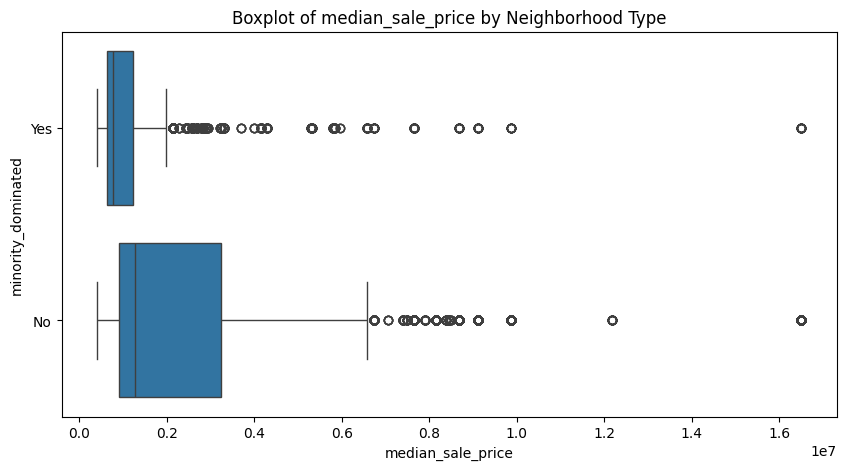

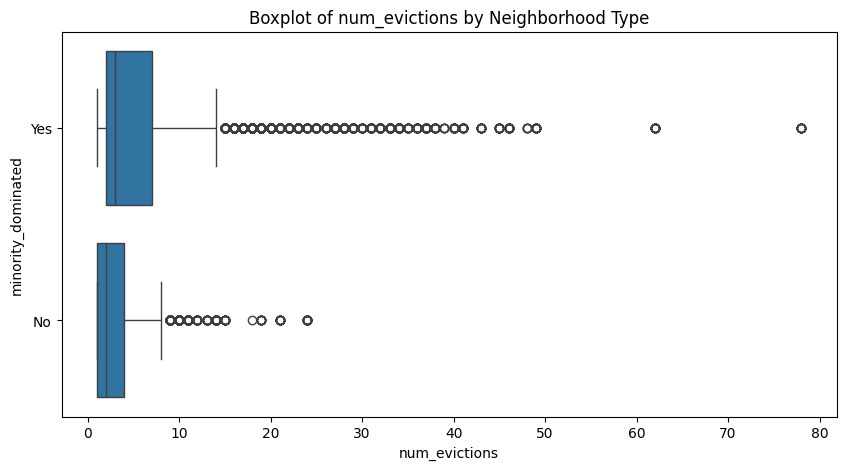

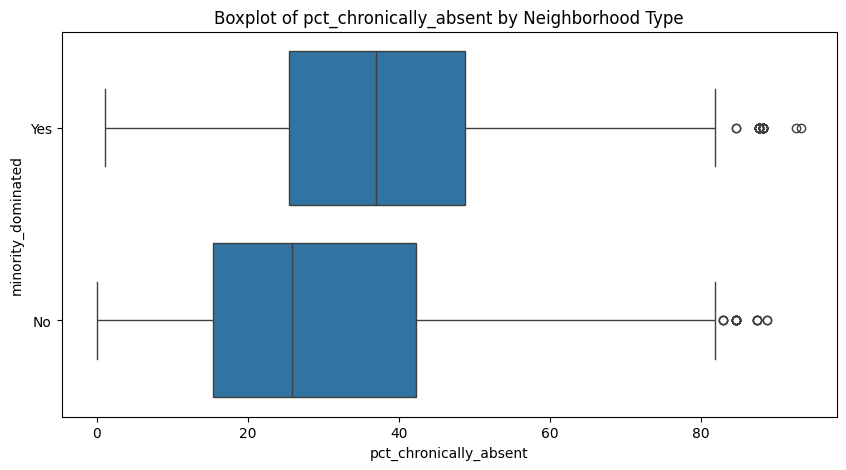

In [17]:
# Plot boxplots of each feature (median housing prices, eviction rates, and school attendance)
# by neighborhood category
features = ['median_sale_price', 'num_evictions', 'pct_chronically_absent']
for i, feature in enumerate(features):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=data, x=feature, y='minority_dominated')
    plt.title(f"Boxplot of {feature} by Neighborhood Type")
plt.show()

In [18]:
# ANOVA tests for housing prices, eviction rates, school attendance for white/minority dominated neighborhoods
for feature in features:
    anovaModel = smf.ols(f"{feature} ~ minority_dominated", data=data).fit()
    table = sm.stats.anova_lm(anovaModel)
    print(f"ANOVA results for {feature}")
    print(table)
    print()

ANOVA results for median_sale_price
                         df        sum_sq       mean_sq            F  PR(>F)
minority_dominated      1.0  2.850846e+16  2.850846e+16  6424.304909     0.0
Residual            35934.0  1.594605e+17  4.437595e+12          NaN     NaN

ANOVA results for num_evictions
                         df        sum_sq       mean_sq            F  PR(>F)
minority_dominated      1.0  7.347930e+04  73479.303557  1818.905666     0.0
Residual            35934.0  1.451645e+06     40.397534          NaN     NaN

ANOVA results for pct_chronically_absent
                         df        sum_sq        mean_sq            F  PR(>F)
minority_dominated      1.0  4.509689e+05  450968.878488  1662.320682     0.0
Residual            35934.0  9.748489e+06     271.288737          NaN     NaN



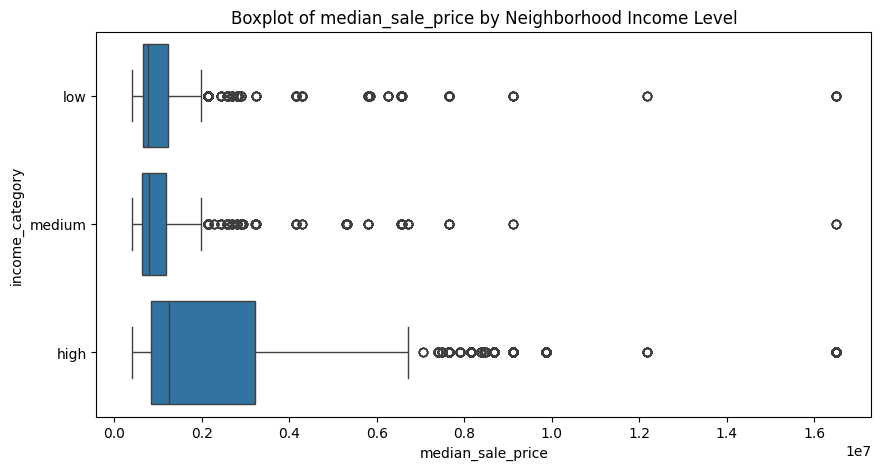

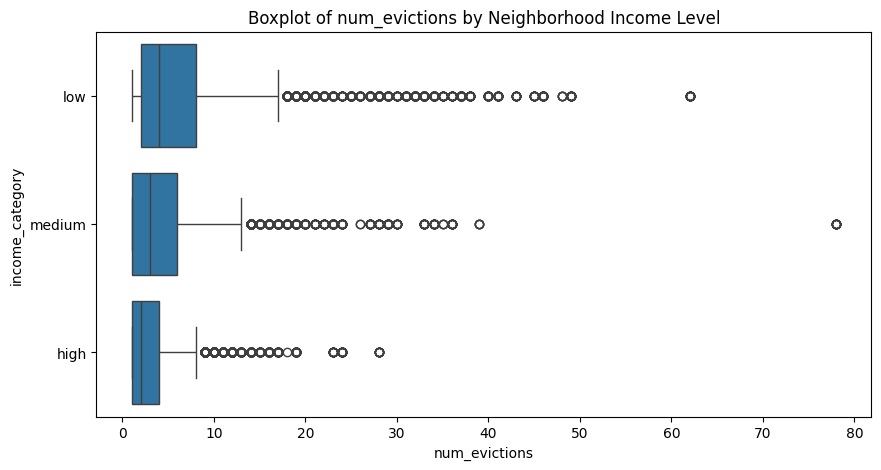

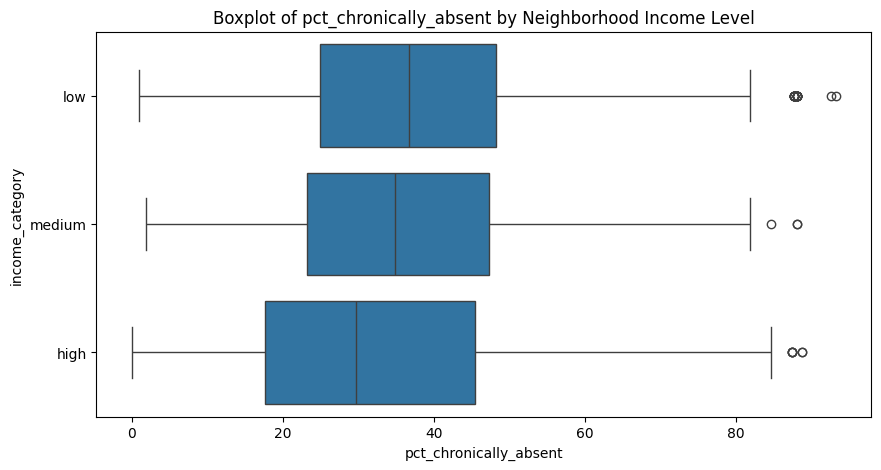

In [23]:
# Boxplots of each feature (median housing prices, eviction rates, and school attendance)
# by neighborhood income category
features = ['median_sale_price', 'num_evictions', 'pct_chronically_absent']
for i, feature in enumerate(features):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=data, x=feature, y='income_category')
    plt.title(f"Boxplot of {feature} by Neighborhood Income Level")
plt.show()

In [24]:
# ANOVA tests for housing prices, eviction rates, school attendance for low/medium/high income neighborhoods
for feature in features:
    anovaModel = smf.ols(f"{feature} ~ minority_dominated", data=data).fit()
    table = sm.stats.anova_lm(anovaModel)
    print(f"ANOVA results for {feature}")
    print(table)
    print()

ANOVA results for median_sale_price
                         df        sum_sq       mean_sq            F  PR(>F)
minority_dominated      1.0  2.850846e+16  2.850846e+16  6424.304909     0.0
Residual            35934.0  1.594605e+17  4.437595e+12          NaN     NaN

ANOVA results for num_evictions
                         df        sum_sq       mean_sq            F  PR(>F)
minority_dominated      1.0  7.347930e+04  73479.303557  1818.905666     0.0
Residual            35934.0  1.451645e+06     40.397534          NaN     NaN

ANOVA results for pct_chronically_absent
                         df        sum_sq        mean_sq            F  PR(>F)
minority_dominated      1.0  4.509689e+05  450968.878488  1662.320682     0.0
Residual            35934.0  9.748489e+06     271.288737          NaN     NaN



From the ANOVA results, we can draw conclusions about the mean differences in median housing prices, number of evictions, and chronic absenteeism across neighborhoods of different racial compositions. Here we consider "minority dominated" neighborhoods, those where the non-white population exceeds 50 percent, and "white dominated" neighborhoods, where the white population exceeds 50 percent.

Using box plots as a first order check, we see that minority-dominated neighborhoods tend to have higher rates of chronic absenteeism and evictions, and lower median housing sale prices on average in comparison to white-dominated neighborhoods. This is borne out by the ANOVA analysis, which shows that the differences in the means of these three features is statistically significant (p << 0.05) between minority and white-dominated neighborhoods.

Looking at median income, we categorize in percentile thirds: 33rd percentile and below is low, 34th to 66th percentile is medium, and 67th percentile and above is high. We see quite a strong relationship emerge in that high income neighborhoods appear to have lower rates of chronic absenteeism and evictions, and higher median housing sale prices on average in comparison to low and medium income neighborhoods. This trend is graduated in all three cases, with medium income neighborhoods adopting a medium value for the feature. The ANOVA analysis confirms statistical significance, which shows that the differences in the means of these three features is statistically significant (p << 0.05) between low, medium, and high income neighborhoods.

We can thus reject the remaining null hypotheses:
5. There is no statistically significant difference in the relationships between housing prices, evictions, and chronic absenteeism between minority and white-dominant neighborhoods.
    - In fact, the relationships between housing prices, evictions, and chronic absenteeism significantly differ between minority and white-dominant neighborhoods.
6. There is no statistically significant difference in the relationships between housing prices, evictions, and chronic absenteeism between neighborhoods of different income levels.
    - In fact, the relationships between housing prices, evictions, and chronic absenteeism differ significantly by neighborhood income level.


## Graphical Analysis

Guidance:

Create various types of plots to visualize relationships within your data. Use histograms, bar charts, scatter plots, box plots, and any other suitable graphical representations you've learned.

Be sure to use appropriate titles, labels, and legends to make your plots readable and informative.

Interpret the graphical representations to uncover patterns, trends, and outliers.


In [19]:
# May be redundant with the above, maybe add some pairplots

## Comparative Analysis

Guidance:

Compare and contrast different subsets of your data. This can include comparisons over time, across different categories, or any other relevant segmentation.  Note that for some projects, the nature of this comparative analysis will be obvious.  For others, you will need to think about how you might subset your data.

Discuss any notable similarities or differences you have identified.


In [27]:
data.columns

Index(['year', 'nta_name', 'borough', 'pct_attendance',
       'pct_chronically_absent', 'num_evictions', 'median_sale_price', 'hvi',
       'total_population', 'median_income', 'white_pct', 'black_pct',
       'american_indian_alaska_native_pct', 'asian_pct',
       'hawaiian_pacific_islander_pct', 'multiple_race_pct', 'other_race_pct',
       'income_category', 'minority_pct', 'minority_dominated'],
      dtype='object')

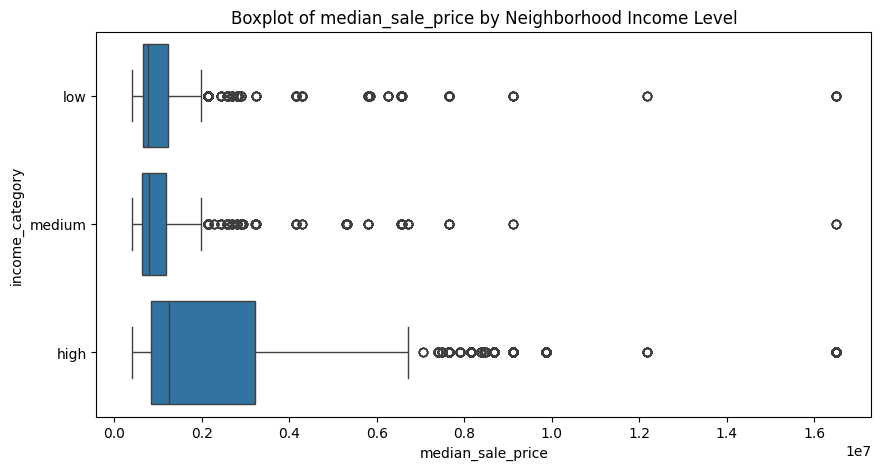

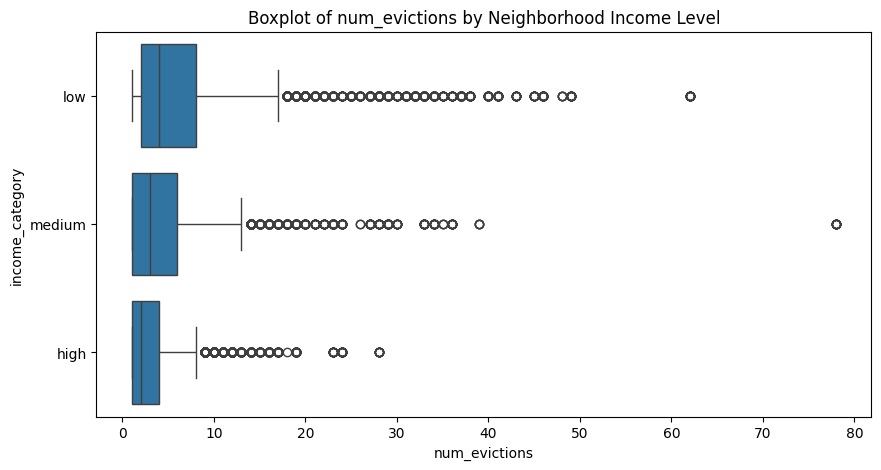

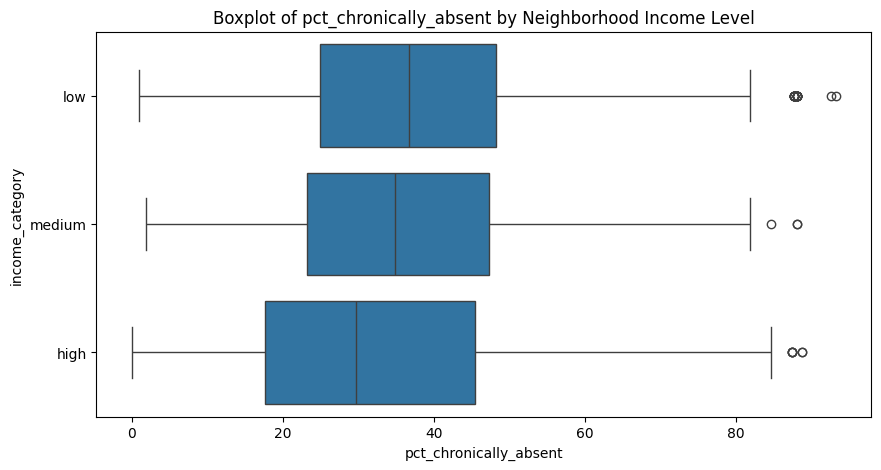

In [25]:
# 1. Reproduced: boxplots of each feature (median housing prices, eviction rates, and school attendance)
# by neighborhood income category
features = ['median_sale_price', 'num_evictions', 'pct_chronically_absent']
for i, feature in enumerate(features):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=data, x=feature, y='income_category')
    plt.title(f"Boxplot of {feature} by Neighborhood Income Level")
plt.show()

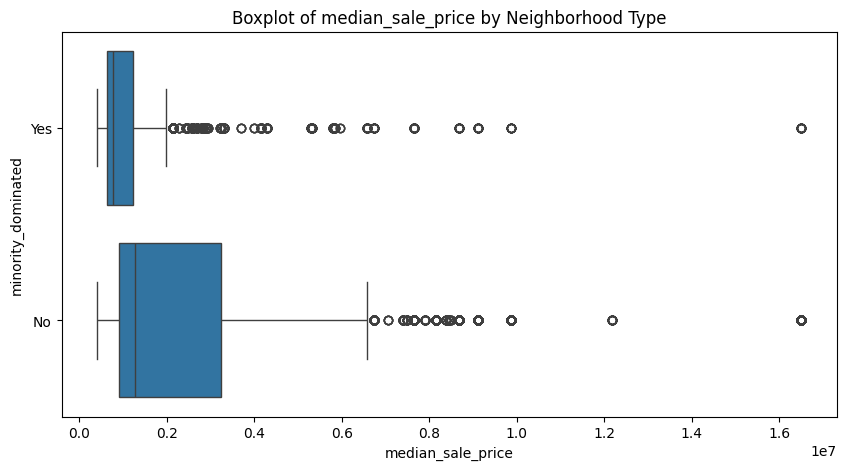

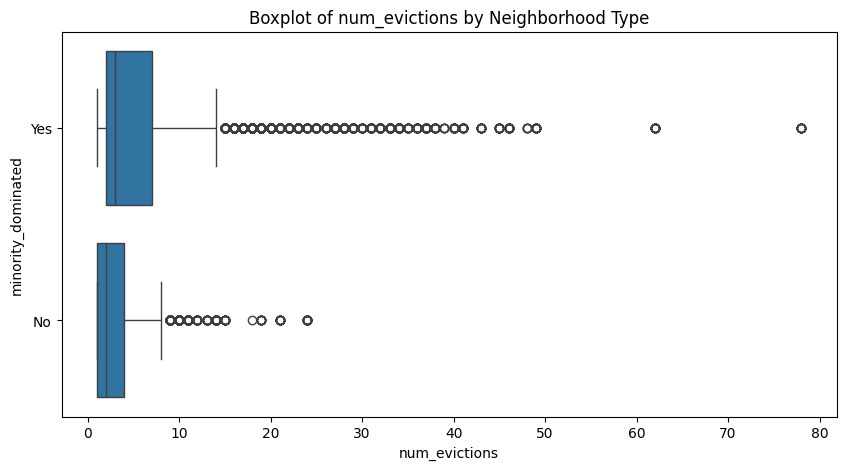

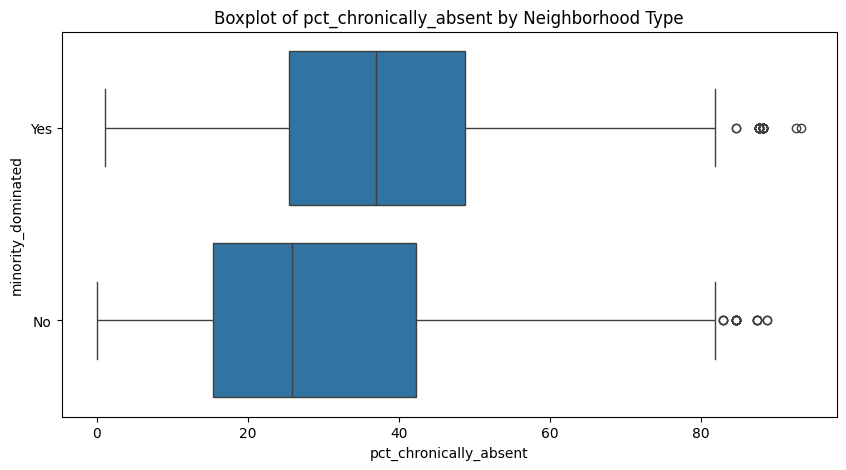

In [22]:
# 2. Reproduced: boxplots of each feature (median housing prices, eviction rates, and school attendance)
# by neighborhood racial category
for i, feature in enumerate(features):
    plt.figure(figsize=(10,5))
    sns.boxplot(data=data, x=feature, y='minority_dominated')
    plt.title(f"Boxplot of {feature} by Neighborhood Type")
plt.show()

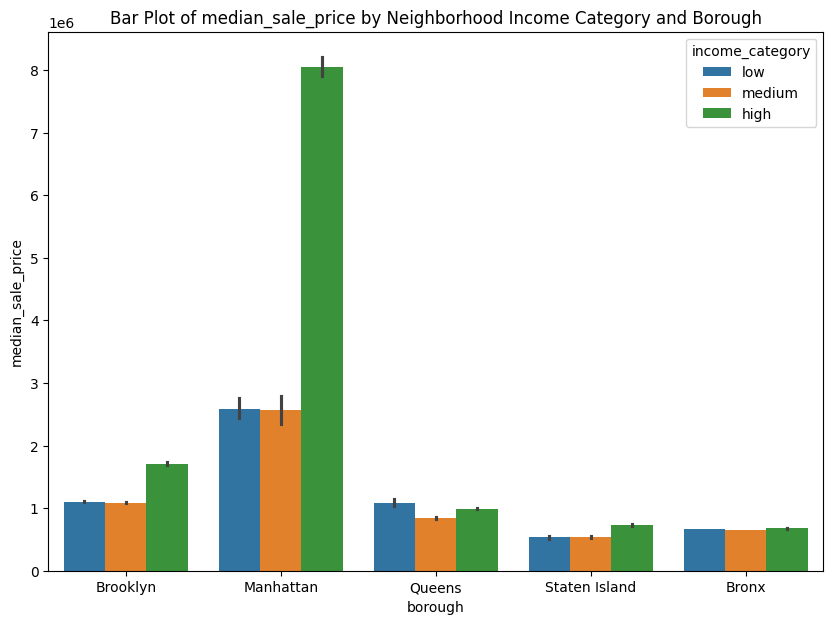

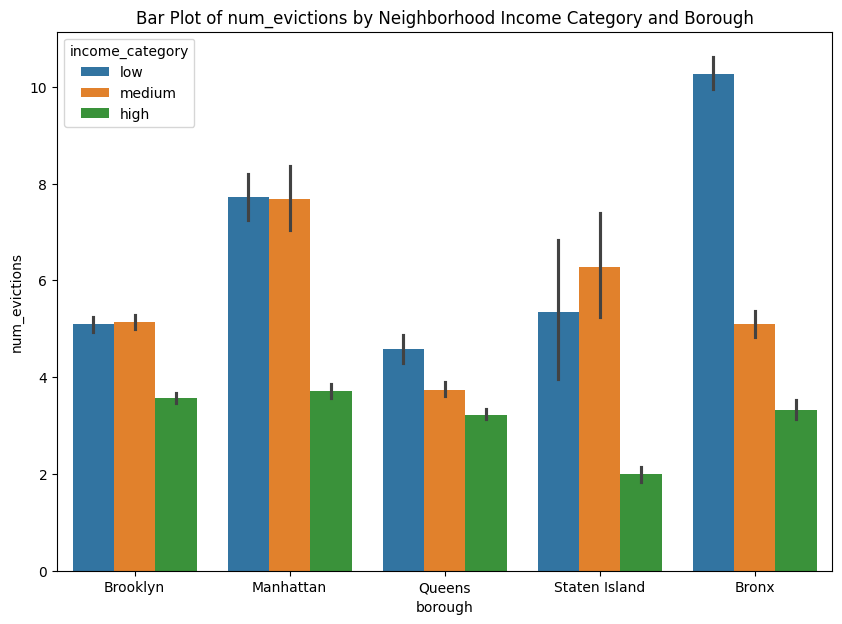

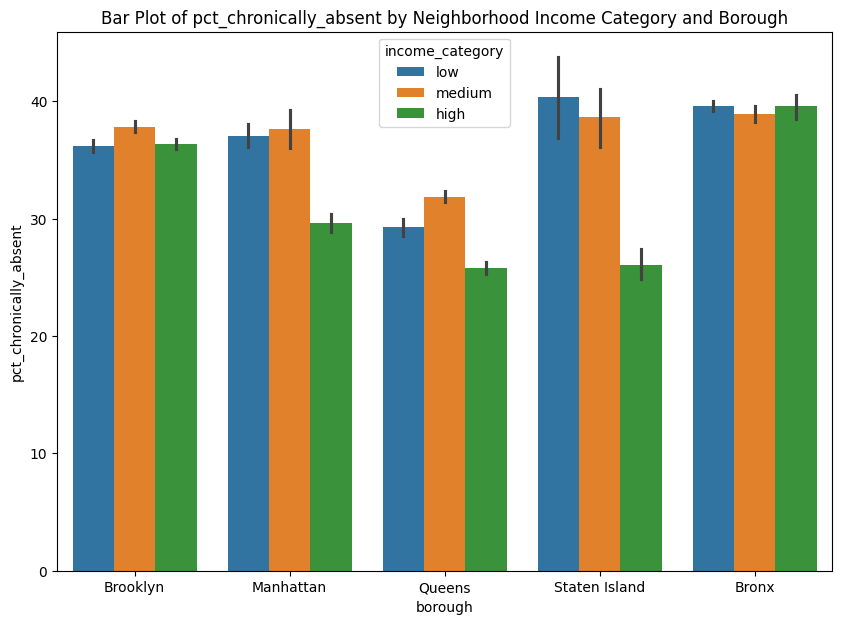

In [31]:
# Features by borough and income category
for i, feature in enumerate(features):
    plt.figure(figsize=(10, 7))
    sns.barplot(data=data, x='borough', y=feature, hue='income_category')
    plt.title(f"Bar Plot of {feature} by Neighborhood Income Category and Borough")
plt.show()

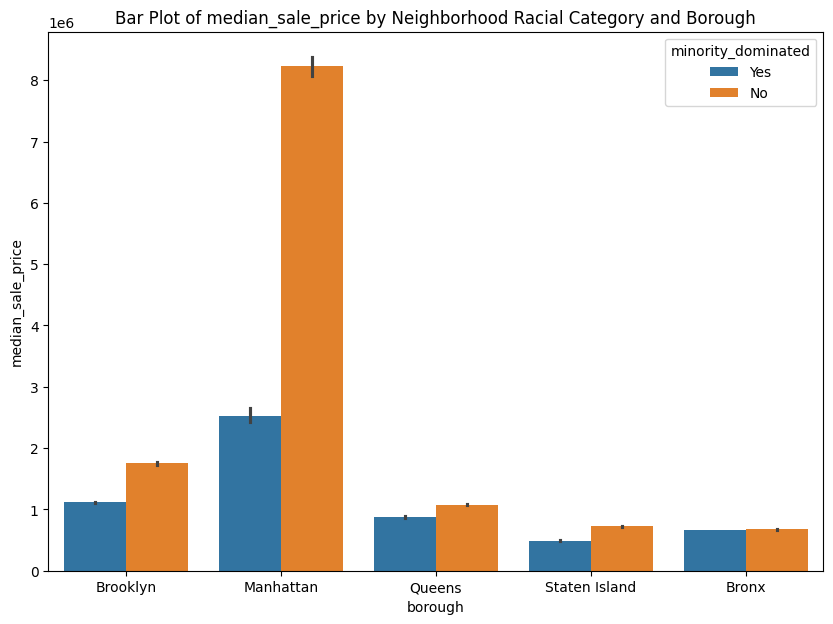

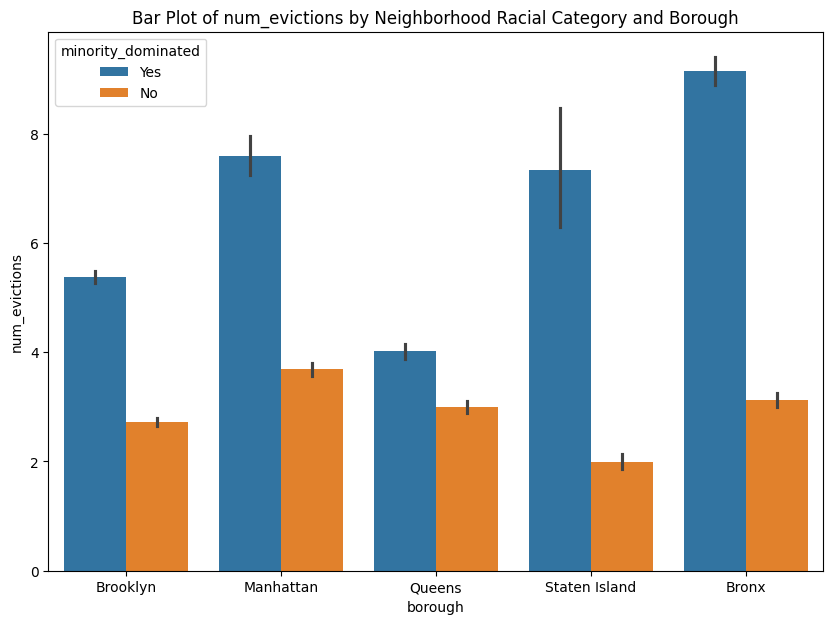

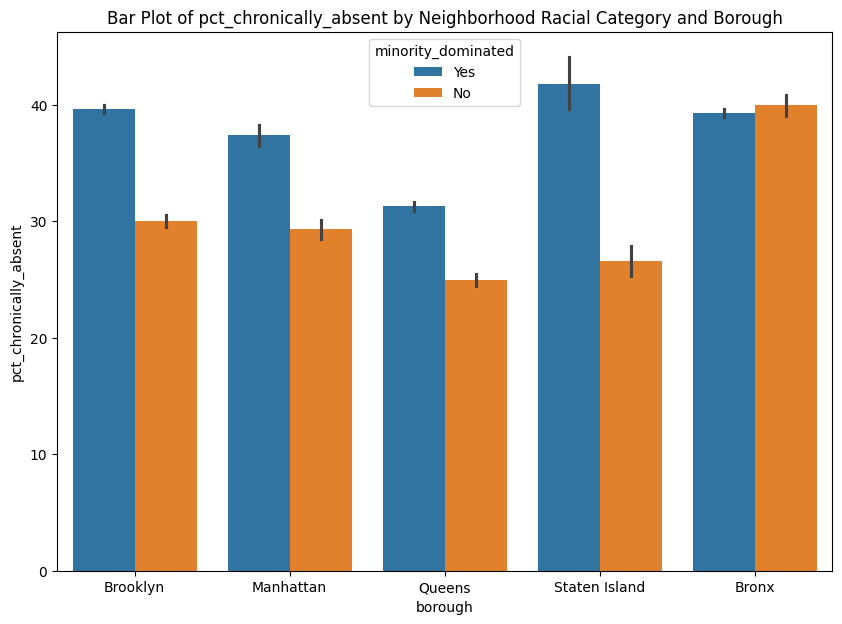

In [35]:
# Features by borough and neighborhood racial category
for i, feature in enumerate(features):
    plt.figure(figsize=(10, 7))
    sns.barplot(data=data, x='borough', y=feature, hue='minority_dominated')
    plt.title(f"Bar Plot of {feature} by Neighborhood Racial Category and Borough")
plt.show()

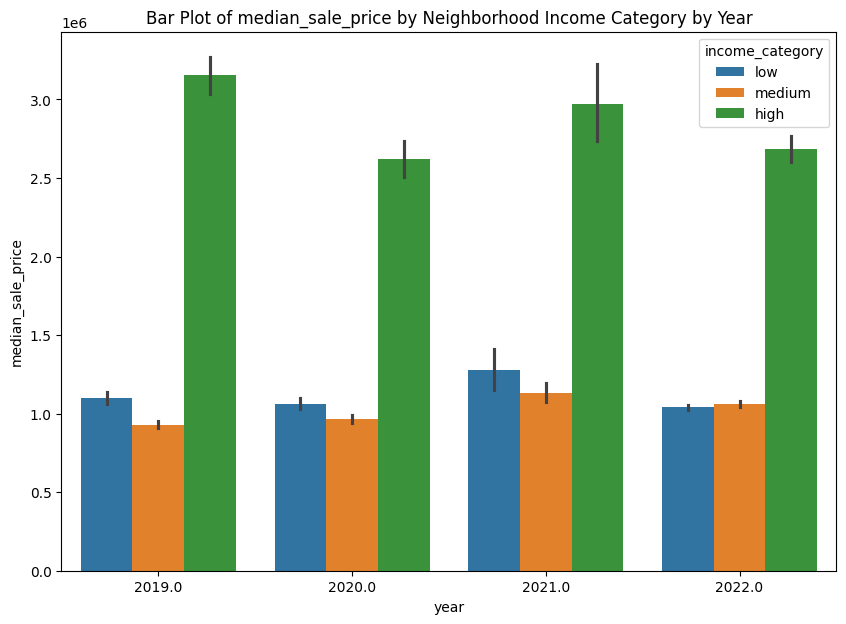

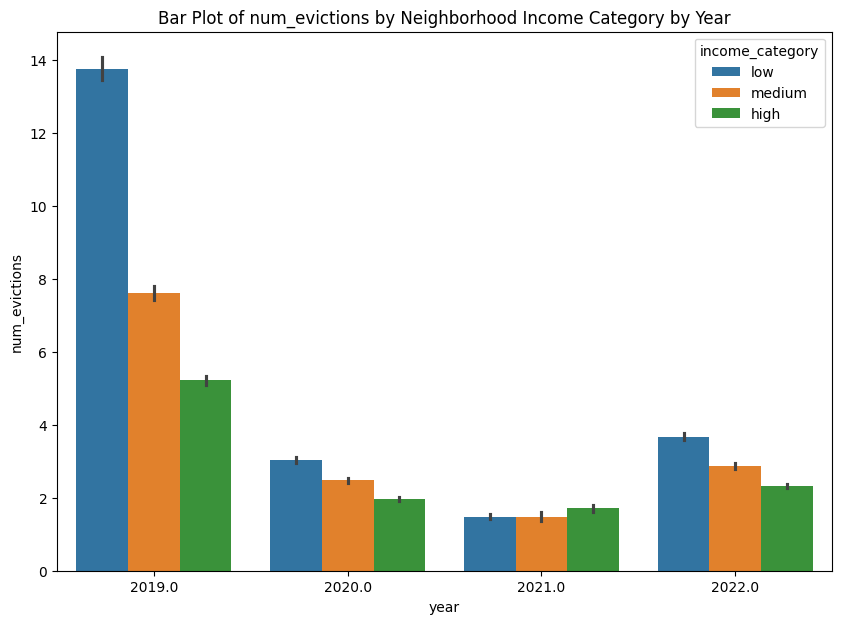

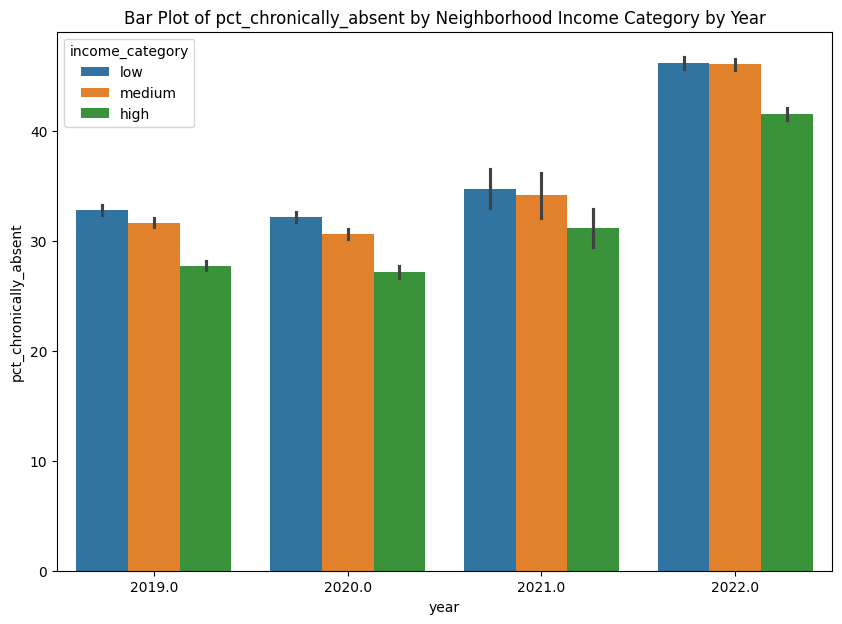

In [36]:
# Features by year and income category
for i, feature in enumerate(features):
    plt.figure(figsize=(10, 7))
    sns.barplot(data=data, x='year', y=feature, hue='income_category')
    plt.title(f"Bar Plot of {feature} by Neighborhood Income Category by Year")
plt.show()

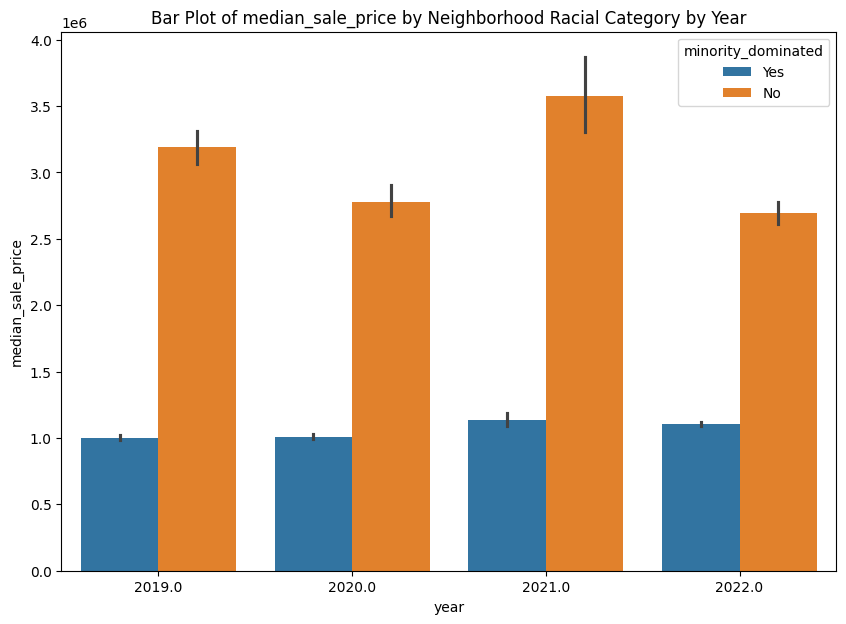

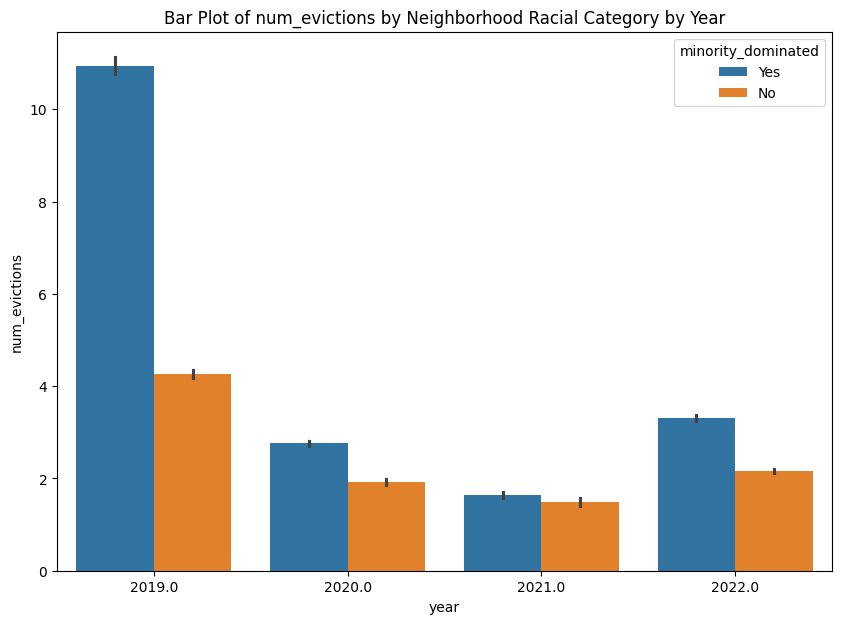

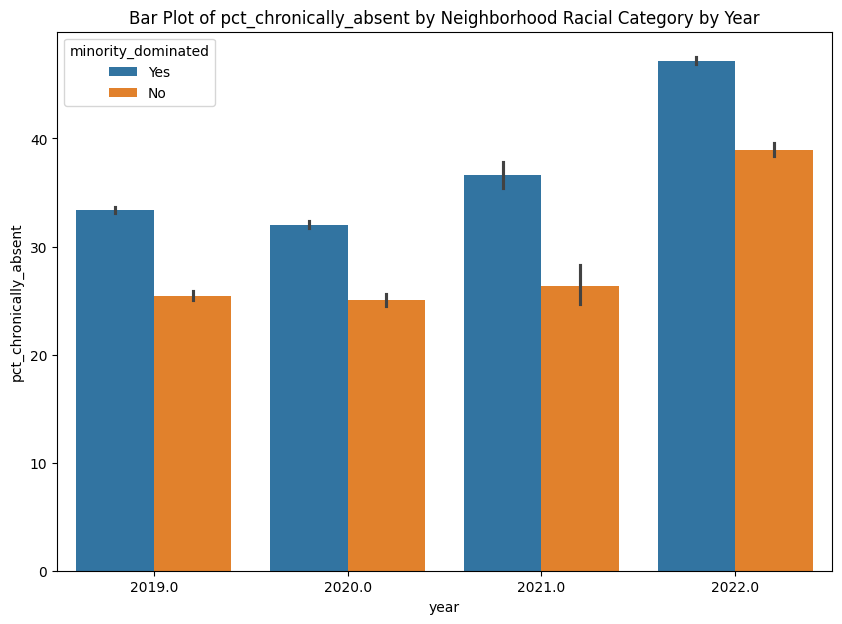

In [38]:
# Features by year and neighborhood racial category
for i, feature in enumerate(features):
    plt.figure(figsize=(10, 7))
    sns.barplot(data=data, x='year', y=feature, hue='minority_dominated')
    plt.title(f"Bar Plot of {feature} by Neighborhood Racial Category by Year")
plt.show()

For a comparative analysis, the most useful segments to examine are race and income level for the purposes of seeing clear and distinct trends/relationships in the data. 

### Minority vs White-Dominated Neighborhoods
Examining the box plots of chronic absenteeism, evictions, and median housing sale prices across white vs minority-dominated neighborhoods, it is clear that minority-dominated neighborhoods tend to have higher rates of evictions, lower median house sale prices, and higher rates of chronic absenteeism. 

This trend holds when looking across the boroughs of NYC. Looking at housing prices, Manhattan we see the starkest divide by race: median sale prices in white neighborhoods are over twice that of minority neighborhoods, whereas the Bronx tends to be more homogenous, prices being on the low end (~ 1M USD) for both categories. The remaining boroughs fall in between these extremes. 

Evictions are also heavily polarized by race across the boroughs, with minority neighborhoods seeing much higher rates of evictions in all, particularly in the Bronx and Staten Island. Finally, chronic absenteeism tends to be higher in minority neighborhoods in all boroughs as well, though the divide is not as stark as with the other two features.

Looking by year in the period 2019-2022, we see that the trends in housing prices, evictions, and chronic absenteeism change across time. The number of evictions and the white/minority disparity is largest in 2019, least in 2021, before widening moderately in 2022. The total eviction count also decreases 2019-2021 before increasing again in 2022. Housing prices oscillate about a mean of 3.25M USD by year, with the minority/white disparity roughly constant. Chronic absenteeism has been rising consistently in both groups from 2019 to 2022, with the relative disparity once again remaining roughly constant. A large confounding factor in these trends that should be mentioned in the COVID-19 pandemic, which was known to have a large impact on housing prices, a suspension of evictions, and school attendance.

Overall, subsetting by race, we see clearly that the issue of housing, evictions and absenteeism is spatially and temporally consistent across the area and time period captured by this data. This would be a clear indicator to policymakers that action is needed to address these disparities.

### Low, Medium, and High Income Neighborhoods
Examining the box plots of the same three features by income category, we see a clear, graduated trend that as median neighborhood household income increases, the number of evictions and chronic absenteeism decrease, and median housing sale prices increase. This makes intuitive sense, those with higher incomes are more likely to be able to afford higher housing costs and have the means and preference for this nicer housing, have less of a reason to skip school (e.g. to work), and are less likely to be evicted due to financial hardship.

This trend largely holds when looking by year in the period 2019-2022. The interesting exceptions are that medium income neighborhoods tend to have lower median sale prices in 2019-2021 than low-income neighborhoods, and that high-income neighborhoods had the most evictions in 2021. As this is the period of the pandemic, we can likely chalk this up to the economic instability and strange circumstances of that time.

Looking across boroughs, we see more variation in the trends. In Brooklyn, Manhattan, and Queens, medium income neighborhoods had the highest chronic absenteeism, whereas in the Bronx, it was roughly even, and in Staten Island the overall inverse trend held. Since missing school has many causes, those are likely to explain the variation here. On evictions, we see for the most part a negative relationship between income and evictions, with Staten Island and Brooklyn being slight exceptions, middle income neighborhoods having slightly more evictions than low income neighborhoods. Housing prices are highest in Manhattan and Brooklyn, and lowest in the Bronx and Staten Island, with the other boroughs falling in between. The trend of housing prices increasing with income is mostly consistent, though Queens appears to have low-income neighborhoods priced higher than high-income neighborhoods. This may simply be due to the high-value properties not being sold during this time period.

## Multivariate Analysis

Guidance:

Perform multivariate analysis to understand the relationships among three or more variables in your dataset.

Use techniques like cross-tabulation, pivot tables, and multivariate graphs.


In [20]:
# Cross-tabulation
# Create a cross-tabulation of neighborhood income category and racial category
crossTab = pd.crosstab(data['income_category'], data['minority_dominated'])
crossTab

minority_dominated,No,Yes
income_category,,
low,1070,10823
medium,2236,9960
high,7928,3919


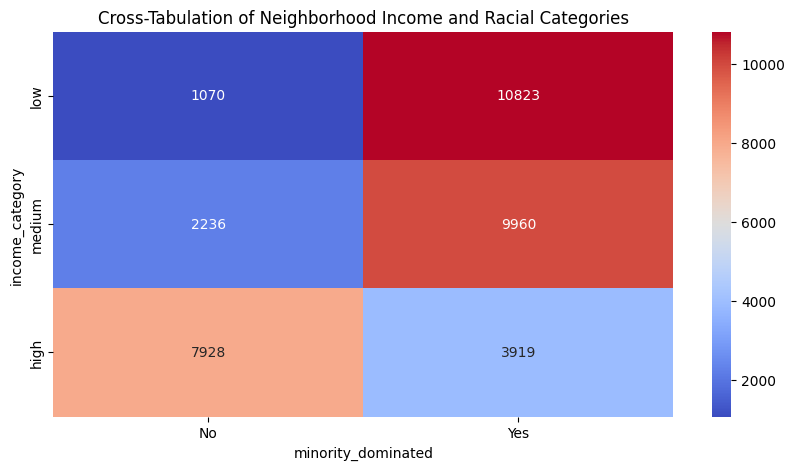

In [39]:
plt.figure(figsize=(10, 5))
sns.heatmap(crossTab, annot=True, cmap='coolwarm', fmt='d')
plt.title("Cross-Tabulation of Neighborhood Income and Racial Categories")
plt.show()

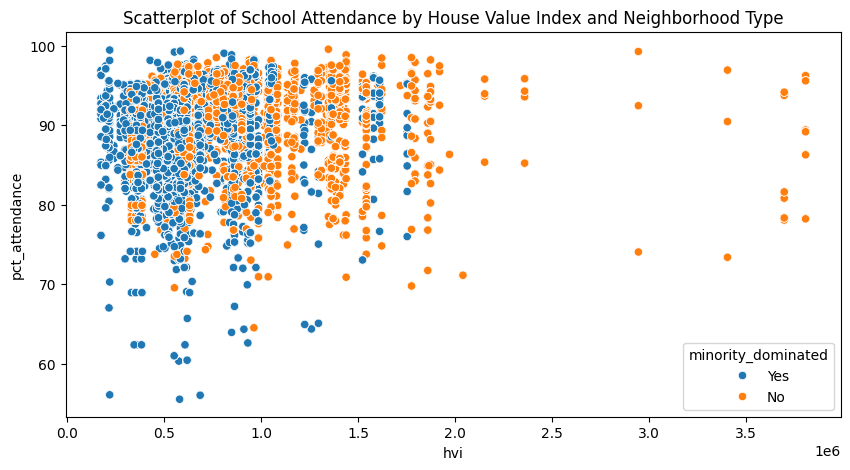

In [ ]:
# Scatterplot of school attendance by house value index and neighborhood type
plt.figure(figsize=(10, 5))
sns.scatterplot(data=data, x='hvi', y='pct_attendance', hue='minority_dominated')
plt.title("Scatterplot of School Attendance by House Value Index and Neighborhood Type")
plt.show()

In [ ]:
# Multiple regression model for school attendance
model = smf.ols('pct_attendance ~ median_income + minority_dominated + hvi + num_evictions', data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         pct_attendance   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     225.8
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          8.21e-192
Time:                        12:29:02   Log-Likelihood:            -1.0981e+05
No. Observations:               35936   AIC:                         2.196e+05
Df Residuals:                   35931   BIC:                         2.197e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

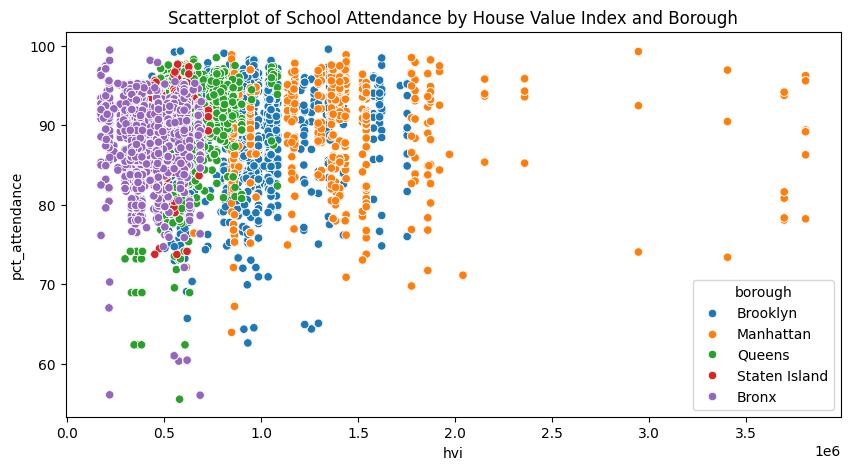

In [ ]:
# Scatterplot of school attendance by house value index and borough
plt.figure(figsize=(10, 5))
sns.scatterplot(data=data, x='hvi', y='pct_attendance', hue='borough')
plt.title("Scatterplot of School Attendance by House Value Index and Borough")
plt.show()

In [ ]:
# Multiple regression model for school attendance
model = smf.ols('pct_attendance ~ median_income + minority_dominated + hvi + num_evictions + C(borough)', data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         pct_attendance   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     259.8
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:29:28   Log-Likelihood:            -1.0924e+05
No. Observations:               35936   AIC:                         2.185e+05
Df Residuals:                   35927   BIC:                         2.186e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In addition to the previous multivariate analyses (multiple regressions, mediation analysis, plotting subsets), this multivariate analysis shows a significant negative association between school attendance rate and median income within the neighborhood. A $10,000 increase in median income is associated with 0.14% increase in the school attendance rate, ceteris paribus. The correlation is still robustly significant after controlling different boroughs. It is a pretty interesting result as it suggests that the higher income neighborhoods tend to have lower school attendance rates. However, the relationship may suffer from omitted variable bias and the coefficient is rather small.

## Synthesis

The inferential analysis shows that there is a significant relationship between housing prices and evictions. Higher housing prices correlate with lower eviction rates. Housing prices mediate the relationship between income and evictions, with income affecting eviction rates both directly and partially through its impact on housing prices. Both channels are statistically significant.

In the second part of our analysis, we found a significant, positive relationship between evictions and school absenteeism. Higher eviction rates are associated with higher rates of chronic absenteeism, underscoring housing instability can negatively impact school attendance and resulting in further achievement gap between students from different socio-economic backgrounds. We also find mediation effects on eviction between income and chronic absenteeism. Evictions partially mediate this relationship, with slightly some of the effect of income on absenteeism is mediated by evictions.

ANOVA analysis shows the difference in housing prices, evictions, and school attendance between white and minority-dominated neighborhoods. Minority-dominated neighborhoods have significantly higher rates of chronic absenteeism and evictions, and lower median housing sale prices on average in comparison to white-dominated neighborhoods. Similarly, there was a statistically significant difference in these three features between income categories, with increasing income correlating with lower absenteeism and evictions, and increasing housing sale prices.

This is further supported by the comparative analysis, which looked at the racial and income categorized subsets across the boroughs and years in the dataset. The same trends in housing prices, evictions, and chronic absenteeism are more-or-less consistent across the area and time period captured by this data. This indicates that this is a city-wide issue that persists over time, and that additional action would be needed by policymakers to address the disparities.

Tying in our research questions, through the analysis presented here, we have confirmed:
1. Housing prices do indeed have an impact on eviction rates in NYC. There is a statistically significant relationship between median housing prices and number of evictions with housing prices being both an independent predictor and a mediator on the influence of income on evictions.
2. That evictions have an impact on quality of childhood education and their educational circumstances, as measured by the percentage of children that are chronically absent in primary and secondary education. Evictions are statistically significant as an independent predictor of chronic absenteeism and partially mediate the relationship between income and absenteeism.
3. That the observed relationships between housing prices, eviction rates, and educational attendance do see some variation across different neighborhoods in NYC and across time, but the overall trend is strong. This confirms that this is not a localized issue in time or space.
4. That the relationships hold for different socioeconomic backgrounds, and that demographics play a role in predicting these relationships.

As we have merged census demographic data, housing price data, school attendance data, and eviction reports to produced the merged dataset, it is clear that we would not be able to see the influence of these factors on each other by considering any component dataset in isolation. The above analysis has grouped by race, income level, location, etc to view trends in the target features of the data, as well as statistically tested the correlations and differences in means between these features/categories. This could not have been done without a combined dataset.


## Reflection

The analysis shows direct and indirect relationships between housing prices, evictions and educational outcomes in NYC neighborhoods and how these outcomes intersect with racial and socio-economic disparities.

Our analysis finds that income impacts eviction rates not only directly but also through its effect on housing prices. Additionally, racial and socioeconomic disparities suggest that factors beyond income and housing prices, possibly including historical inequities and access to resources, play a significant role in shaping housing and educational outcomes in these neighborhoods. This nuanced understanding supports policy interventions that address both economic and social dimensions to effectively reduce eviction rates and improve neighborhood stability.

The analysis also highlights the multifaceted influence of income on absenteeism and the mediation effects of eviction rates. Higher income not only reduces absenteeism directly but also lowers eviction rates, which further contributes to higher school attendance. It underscores the importance of stable housing in supporting consistent school attendance, particularly in lower-income neighborhoods. These findings suggest that policies aimed at reducing evictions in low-income areas could have a beneficial impact on school attendance rates, thereby improving educational outcomes for students in vulnerable housing situations.

We also found neighborhood racial composition correlates with substantial disparities in key socioeconomic indicators, such as housing stability and educational outcomes. The higher rates of absenteeism and evictions, along with lower housing prices in minority-dominated neighborhoods. Our findings underscore the need for targeted interventions that address housing security and other needs for students from low-income and marginalized communities.

Of course, we must qualify by stating that a reduction of complex socioeconomic phenomena such as school truancy and evictions to a few variables likely oversimplifies the problem. The relationships between housing prices, eviction rates, and school attendance are likely to be mediated by a variety of other factors, such as income, employment, and social services.

In terms of data gathering, it was somewhat of a challenge to merge the datasets together. We needed to aggregate house-level evictions data and school-level attendance data to the neighborhood level without the neighborhoods being provided in these datasets for easy matching. This required a lot of cleaning, latitude/longitude matching, etc to combine the datasets on location and year.